In [43]:
import os
import time
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_classic, scale_color_manual, geom_abline

# Data preprocessing
transform = transforms.Compose([
  transforms.Lambda(lambda img: img.crop((20, 0, 150, 130))),  # Crop
  transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
])

class GuessTheCorrelationDataset(Dataset):
  def __init__(self, root, transform=None, indexes=None):
    self.root = root
    self.transform = transform
    self.img_dir = os.path.join(root, 'train_imgs')
    
    # Load correlation values
    csv_path = os.path.join(root, 'train_responses.csv')
    df = pd.read_csv(csv_path)
    
    # Filter by indexes if provided
    if indexes is not None:
      df = df.loc[df.index.isin(indexes)]
    
    self.img_files = df['id'].astype(str) + '.png'
    self.correlations = df['corr'].values
  
  def __len__(self):
    return len(self.img_files)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_files.iloc[idx])
    image = Image.open(img_path).convert('L')  # Convert to grayscale
    
    if self.transform:
      image = self.transform(image)
    
    correlation = torch.tensor(self.correlations[idx], dtype=torch.float32)
    
    return image, correlation

# Model definition
class CorrCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
    self.fc1 = nn.Linear(128 * 14 * 14, 128)  # Adjusted input size
    self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = nn.functional.avg_pool2d(x, 2)
    
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = nn.functional.avg_pool2d(x, 2)
    
    x = self.conv3(x)
    x = nn.functional.relu(x)
    x = nn.functional.avg_pool2d(x, 2)
    
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = nn.functional.relu(x)
    
    return self.fc2(x)


In [44]:
root = os.path.expanduser("~/Documents/PyTorch_Data/correlation/guess-the-correlation")
train_imgs_path = os.path.join(root, 'train_imgs')

num_images = len([name for name in os.listdir(train_imgs_path) if os.path.isfile(os.path.join(train_imgs_path, name))])

print(f"Number of images: {num_images}")

Number of images: 150000


In [45]:
# Dataset creation
train_ds = GuessTheCorrelationDataset(root, transform=transform, indexes=range(30000))
valid_ds = GuessTheCorrelationDataset(root, transform=transform, indexes=range(30000, 40000))
test_ds = GuessTheCorrelationDataset(root, transform=transform, indexes=range(40000, 50000))

# DataLoader creation
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

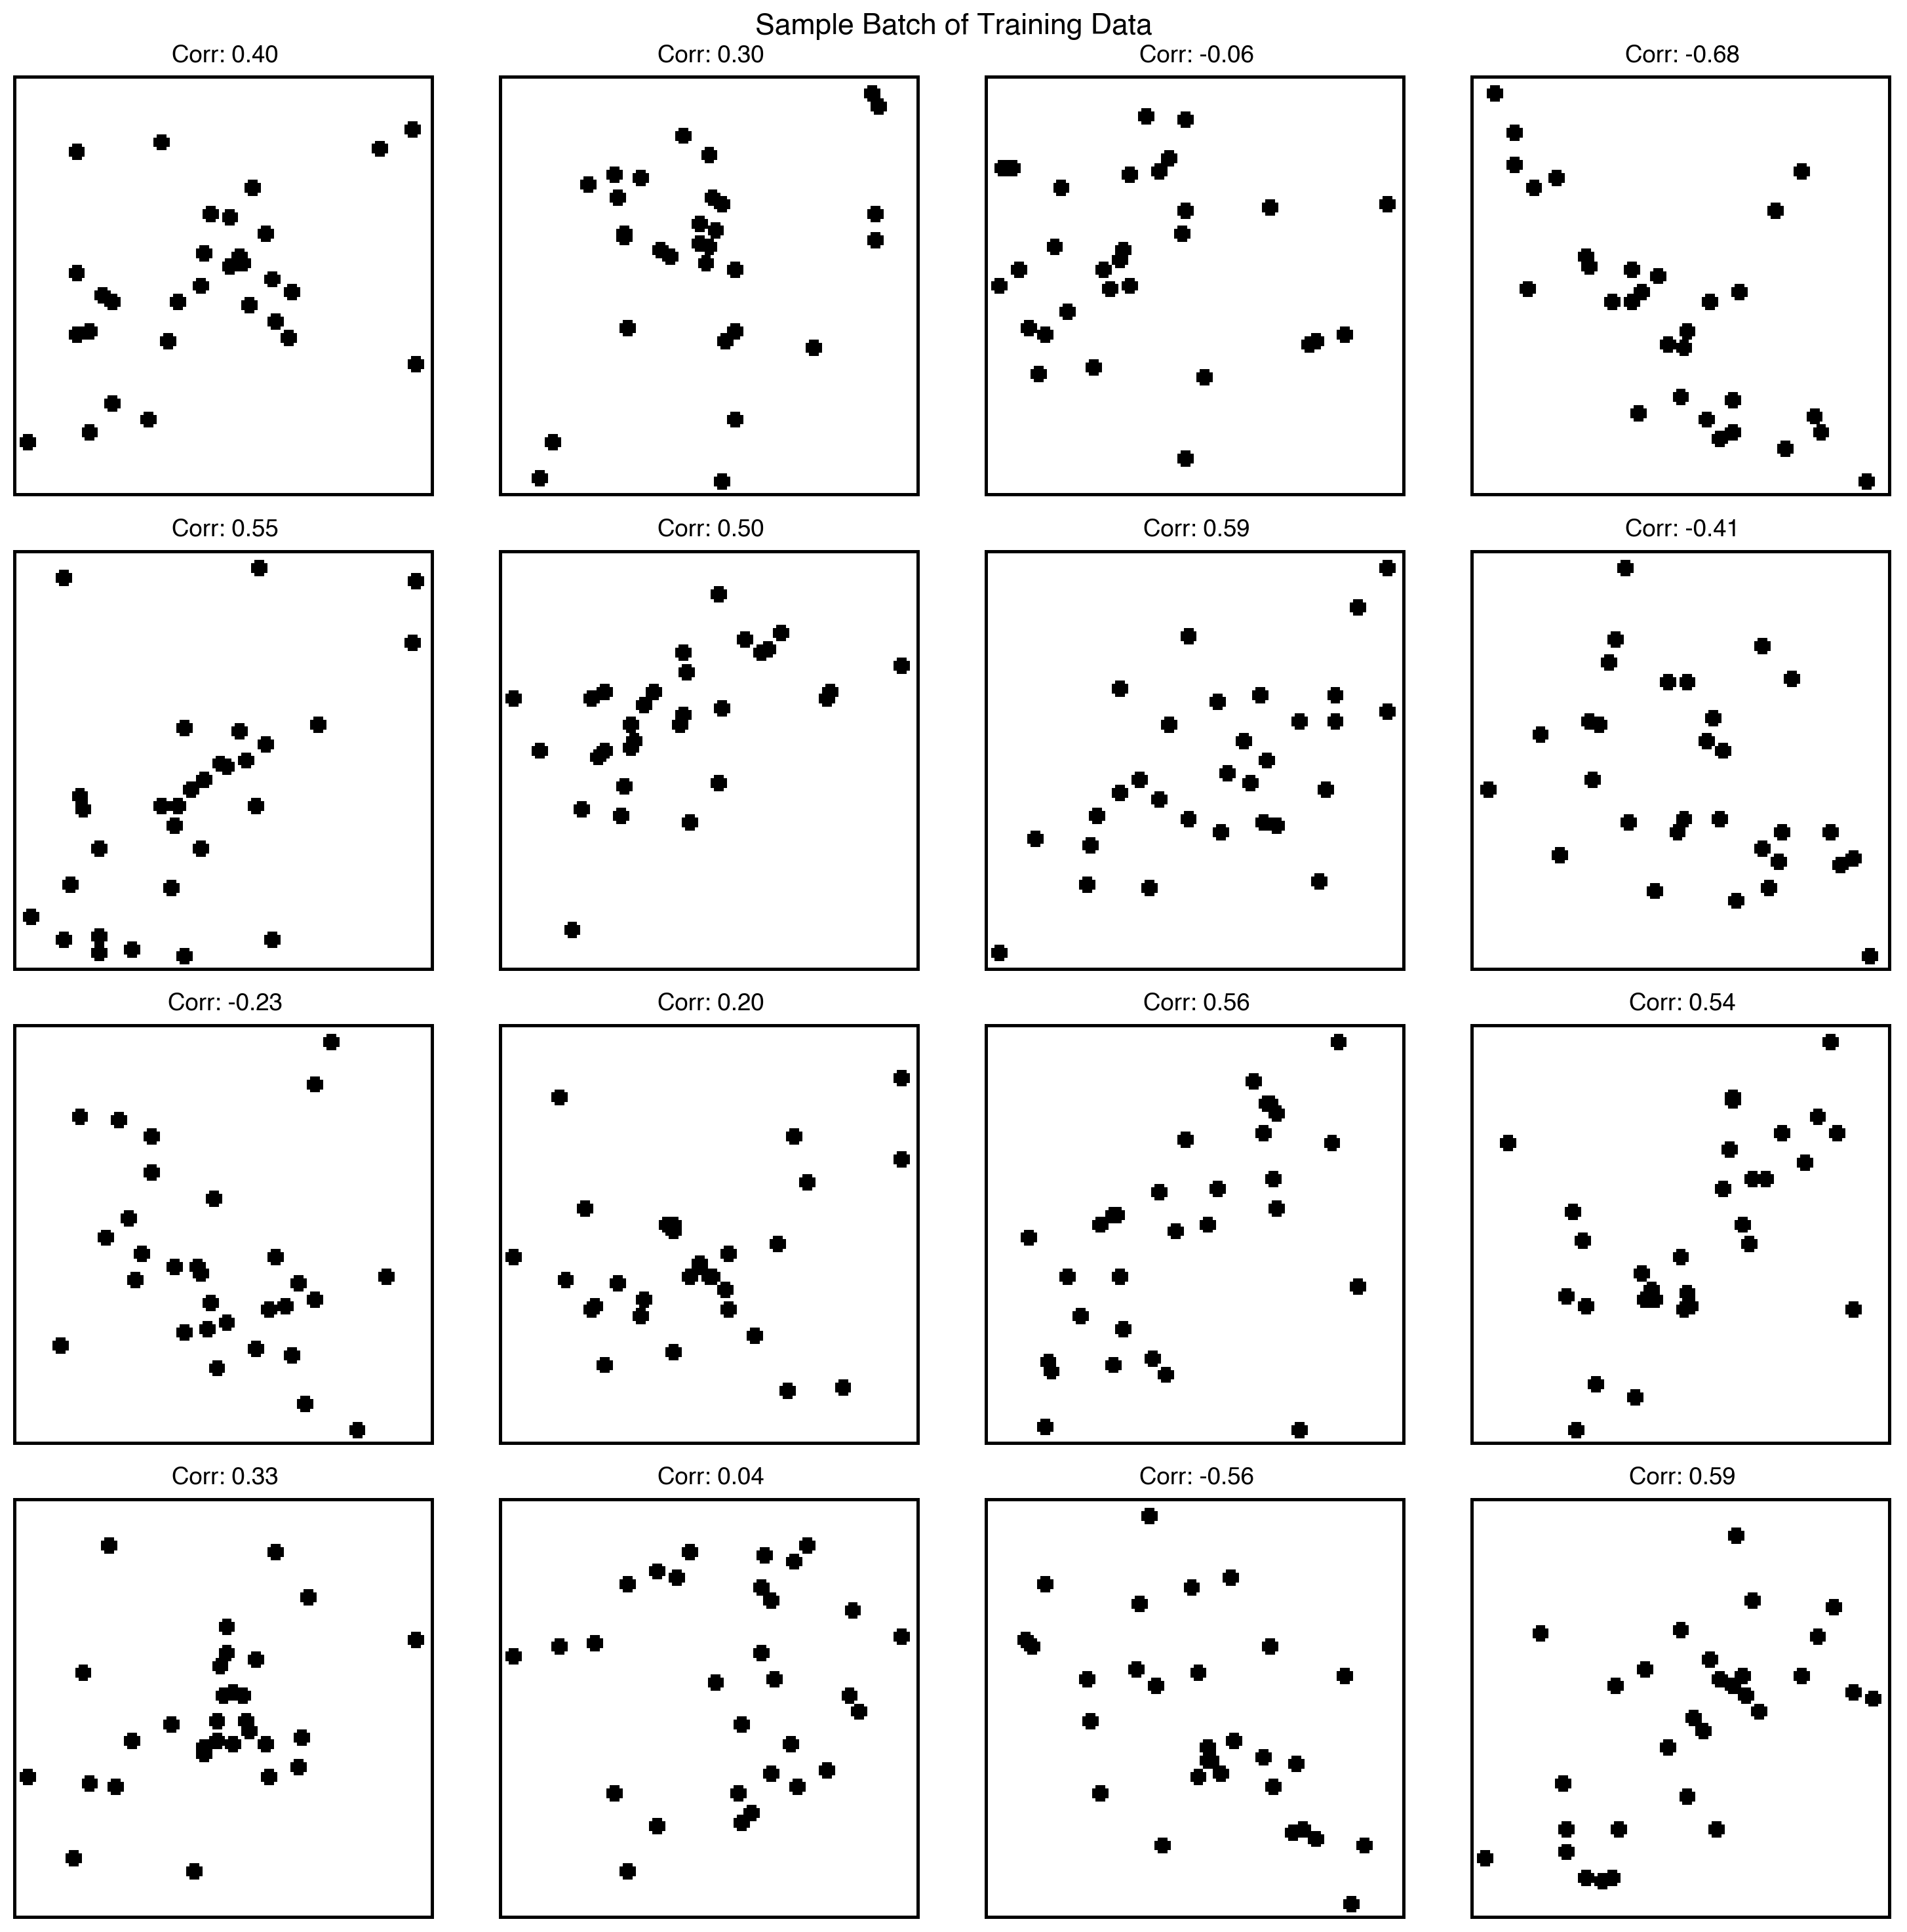

In [46]:
def plot_batch(dataloader, num_images=16):
  # Get a batch of training data
  images, correlations = next(iter(dataloader))
  
  # Convert images from tensor to numpy array
  images = images.numpy()
  
  # Create a grid to plot the images
  num_rows = int(np.ceil(np.sqrt(num_images)))
  num_cols = int(np.ceil(num_images / num_rows))
  
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
  fig.suptitle("Sample Batch of Training Data", fontsize=16)
  
  for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    # Plot the image
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.axis('off')
    
    # Add the correlation value as a title
    ax.set_title(f"Corr: {correlations[i]:.2f}")
  
  # Remove any unused subplots
  for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

  plt.tight_layout()
  plt.show()

# Usage:
plot_batch(train_dl, num_images=16)

In [47]:
# Model instantiation and moving to device
def get_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  elif torch.backends.mps.is_available():
    return torch.device("mps")
  else:
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
model = CorrCNN().to(device)

# Print model summary to verify dimensions
def print_model_summary(model, input_size):
  summary = []
  def register_hook(module):
    def hook(module, input, output):
      class_name = str(module.__class__).split(".")[-1].split("'")[0]
      module_idx = len(summary)
      m_key = f"{class_name}-{module_idx+1}"
      summary.append(
          [m_key, str(input[0].size()), str(output.size())]
      )
    if not list(module.children()):
        hooks.append(module.register_forward_hook(hook))

  hooks = []
  model.apply(register_hook)
  
  x = torch.randn(1, *input_size).to(next(model.parameters()).device)
  model(x)
  
  for h in hooks:
    h.remove()
  
  print("----------------------------------------------------------------")
  print("{:>20}  {:>25} {:>15}".format("Layer (type)", "Input Shape", "Output Shape"))
  print("================================================================")
  for layer in summary:
      print("{:>20}  {:>25} {:>15}".format(layer[0], layer[1], layer[2]))
  print("----------------------------------------------------------------")

# Print model summary
print_model_summary(model, (1, 131, 130))


Using device: mps
----------------------------------------------------------------
        Layer (type)                Input Shape    Output Shape
            Conv2d-1  torch.Size([1, 1, 131, 130]) torch.Size([1, 32, 129, 128])
            Conv2d-2  torch.Size([1, 32, 64, 64]) torch.Size([1, 64, 62, 62])
            Conv2d-3  torch.Size([1, 64, 31, 31]) torch.Size([1, 128, 29, 29])
            Linear-4     torch.Size([1, 25088]) torch.Size([1, 128])
            Linear-5       torch.Size([1, 128]) torch.Size([1, 1])
----------------------------------------------------------------


In [48]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
def train(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
  train_losses = []
  valid_losses = []
  
  for epoch in range(epochs):
      model.train()
      train_loss = 0.0
      for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
      
      train_loss /= len(train_loader)
      train_losses.append(train_loss)
      
      # Validation
      model.eval()
      valid_loss = 0.0
      with torch.no_grad():
        for batch in valid_loader:
          inputs, targets = batch
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), targets)
          valid_loss += loss.item()
    
      valid_loss /= len(valid_loader)
      valid_losses.append(valid_loss)
      
      print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")
  
  return train_losses, valid_losses

# Train the model
start_time = time.time()
epochs = 10
train_losses, valid_losses = train(model, train_dl, valid_dl, criterion, optimizer, epochs, device)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")


Epoch 1, Train Loss: 0.0401, Validation Loss: 0.0041
Epoch 2, Train Loss: 0.0027, Validation Loss: 0.0019
Epoch 3, Train Loss: 0.0015, Validation Loss: 0.0013
Epoch 4, Train Loss: 0.0013, Validation Loss: 0.0014
Epoch 5, Train Loss: 0.0009, Validation Loss: 0.0009
Epoch 6, Train Loss: 0.0007, Validation Loss: 0.0008
Epoch 7, Train Loss: 0.0006, Validation Loss: 0.0009
Epoch 8, Train Loss: 0.0006, Validation Loss: 0.0008
Epoch 9, Train Loss: 0.0005, Validation Loss: 0.0007
Epoch 10, Train Loss: 0.0006, Validation Loss: 0.0008
Training time: 298.2427809238434 seconds


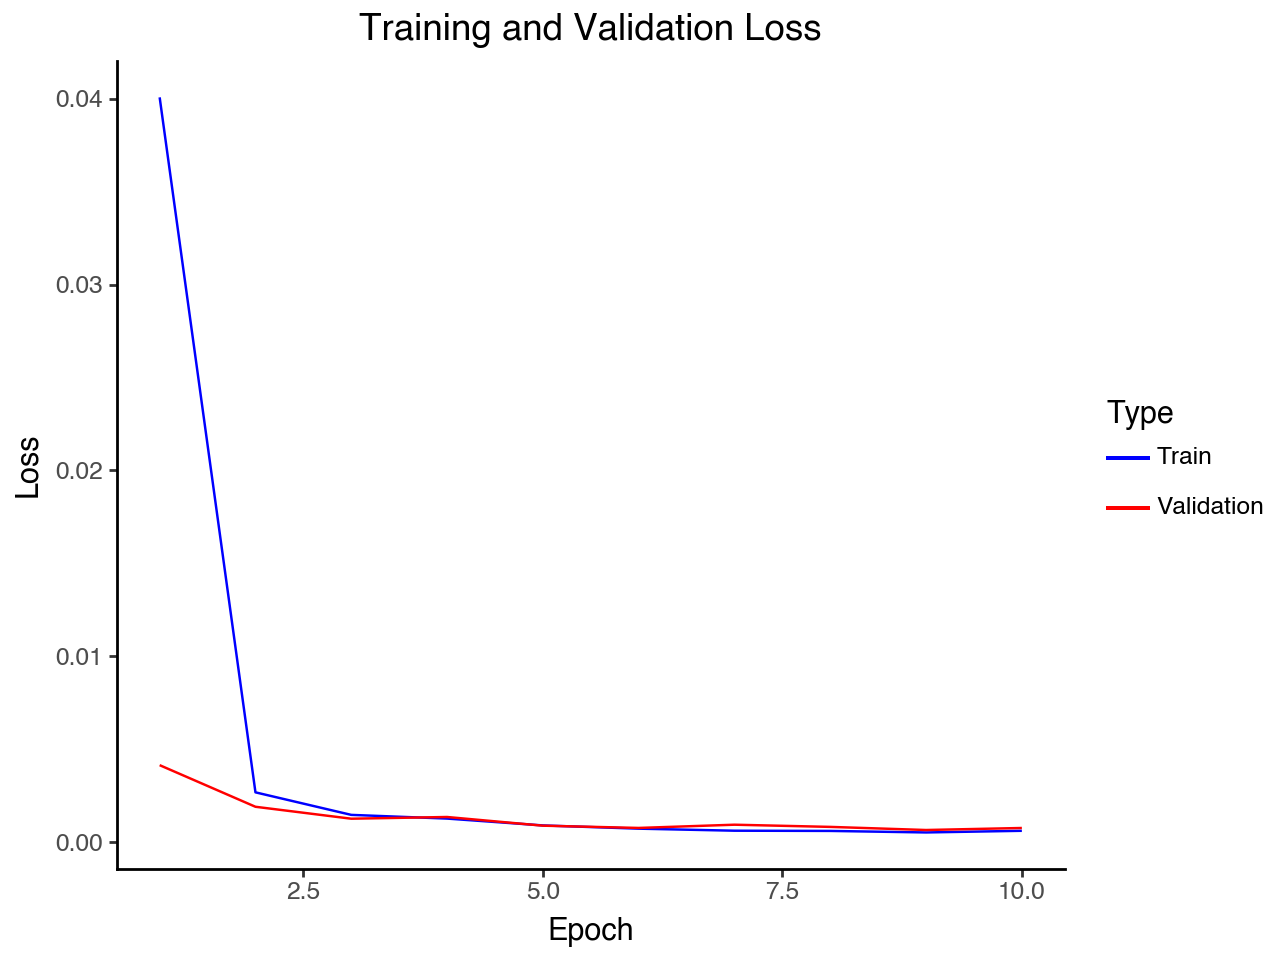

In [49]:
# For the training and validation loss plot
loss_data = pd.DataFrame({
  'Epoch': list(range(1, epochs+1)) * 2,
  'Loss': train_losses + valid_losses,
  'Type': ['Train'] * epochs + ['Validation'] * epochs
})

loss_plot = (ggplot(loss_data, aes('Epoch', 'Loss', color='Type'))
  + geom_line()
  + labs(title='Training and Validation Loss', x='Epoch', y='Loss')
  + theme_classic()
  + scale_color_manual(values=['blue', 'red'])
)

loss_plot.show()

Test MSE: 0.0007
Test RMSE: 0.0270


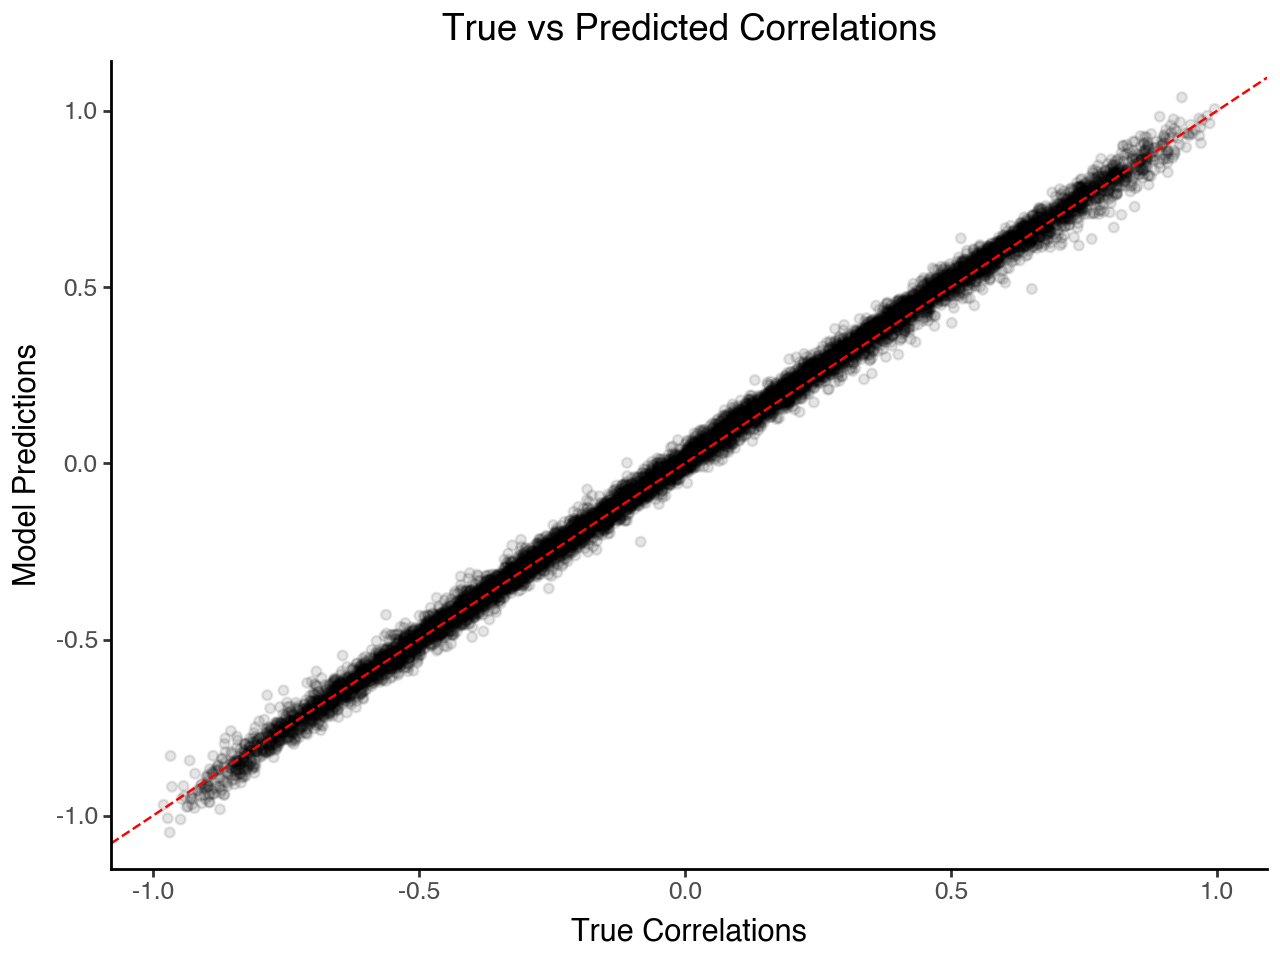

In [50]:
def calculate_test_mse(model, test_loader, device):
  model.eval()  # Set the model to evaluation mode
  all_predictions = []
  all_targets = []
  
  with torch.no_grad():  # No need to track gradients
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      outputs = model(inputs)
      predictions = outputs.squeeze().cpu().numpy()
      all_predictions.extend(predictions)
      all_targets.extend(targets.numpy())

  # Convert lists to numpy arrays
  all_predictions = np.array(all_predictions)
  all_targets = np.array(all_targets)
  
  # Calculate MSE
  mse = np.mean((all_targets - all_predictions) ** 2)
  
  return mse, all_predictions, all_targets

# Assuming you have your model and test_dl (test DataLoader) defined
model = model.to(device)  # Ensure model is on the correct device

# Calculate MSE and get predictions and targets
test_mse, predictions, targets = calculate_test_mse(model, test_dl, device)
print(f"Test MSE: {test_mse:.4f}")

# Optionally, calculate RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(test_mse)
print(f"Test RMSE: {test_rmse:.4f}")

# For the true vs predicted correlations plot
correlation_data = pd.DataFrame({
  'True': targets,
  'Predicted': predictions
})

correlation_plot = (ggplot(correlation_data, aes('True', 'Predicted'))
  + geom_point(alpha=0.1)
  + geom_abline(slope=1, intercept=0, color='red', linetype='dashed')
  + labs(title='True vs Predicted Correlations', 
         x='True Correlations', 
         y='Model Predictions')
  + theme_classic()
)

correlation_plot.show()